In [2]:
# Basic packages
import numpy as np
import time
import sys
import os
from pathlib import Path
import logging
import importlib


# import warnings
# warnings.filterwarnings("ignore")

# Astropy packages
from astropy.table import Table
from astropy.io import fits

# Matplotlib packages
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy.optimize import curve_fit
from scipy import signal


import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore')


# Useful if working in SSH Vscode
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)
import AnalysisFunctions as af
from stellarmodel import StellarModel


sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap


isochrone_interpolator = af.load_isochrones()

GALAH_DR4_dir = '/avatar/buder/GALAH_DR4/'
if 'GALAH_DR4' not in locals():
    GALAH_DR4 = ap.FitsToDF(GALAH_DR4_dir + "catalogs/galah_dr4_allspec_240207.fits")




/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis/


Succsefully found file for object /avatar/buder/GALAH_DR4/observations/131216/spectra/com/1312160021011391.fits


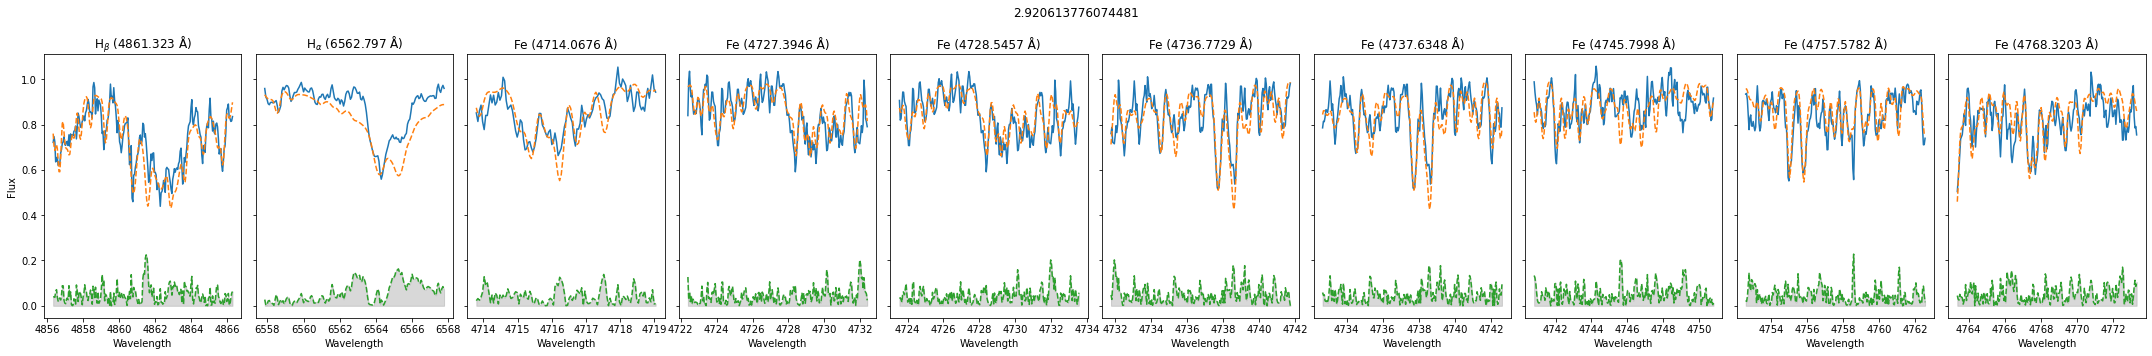

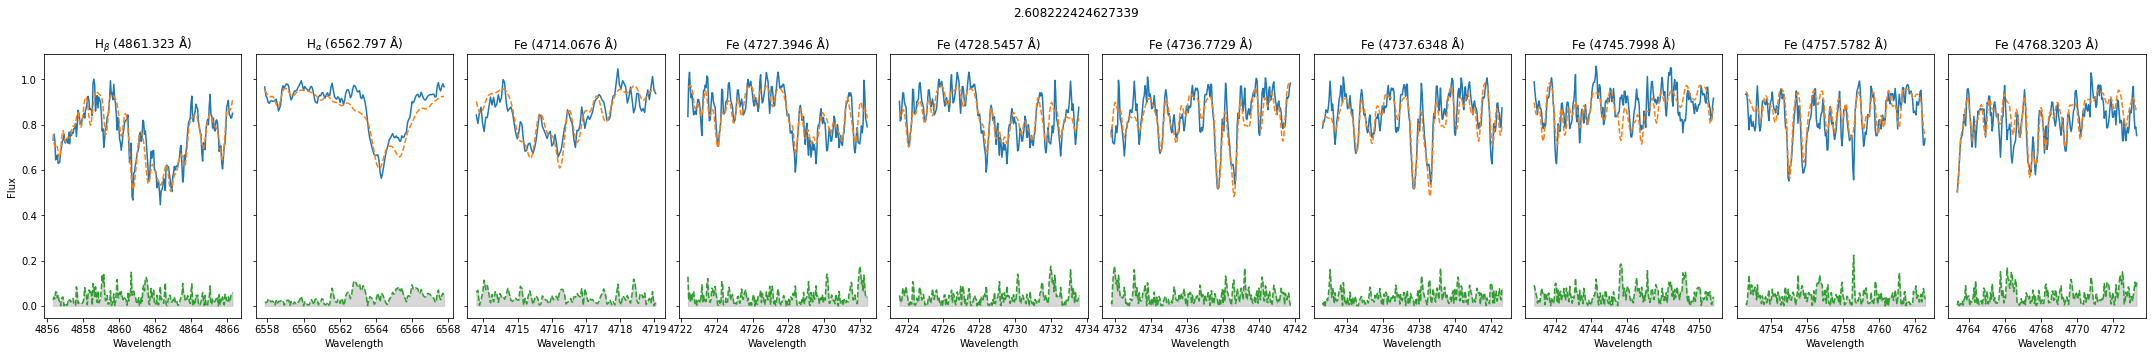

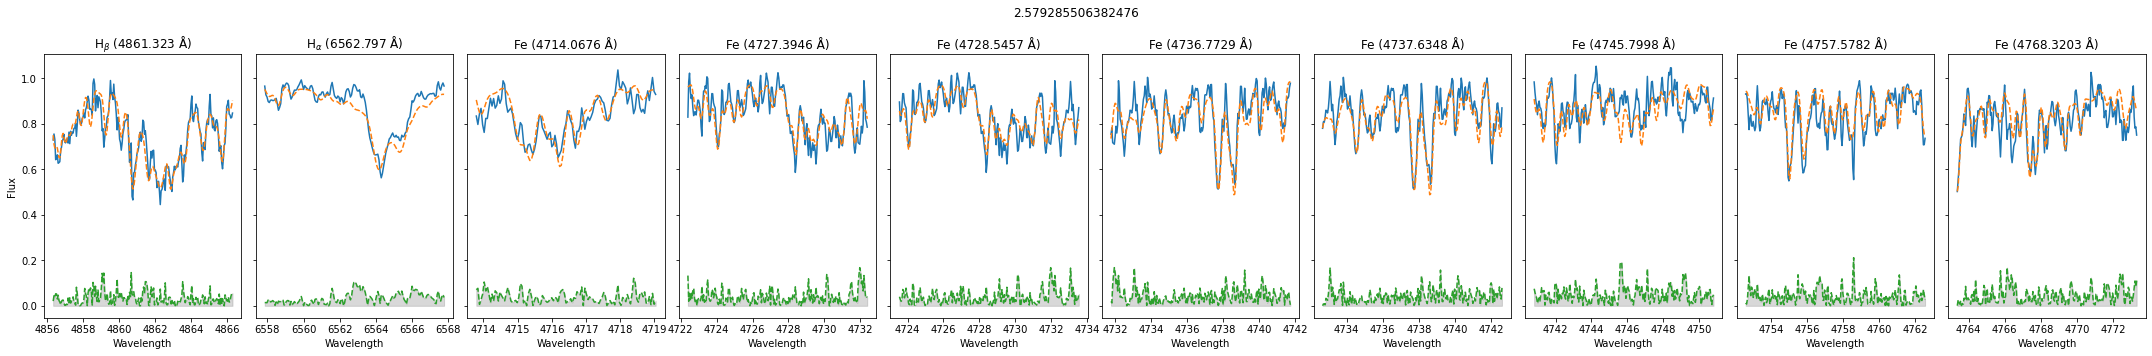

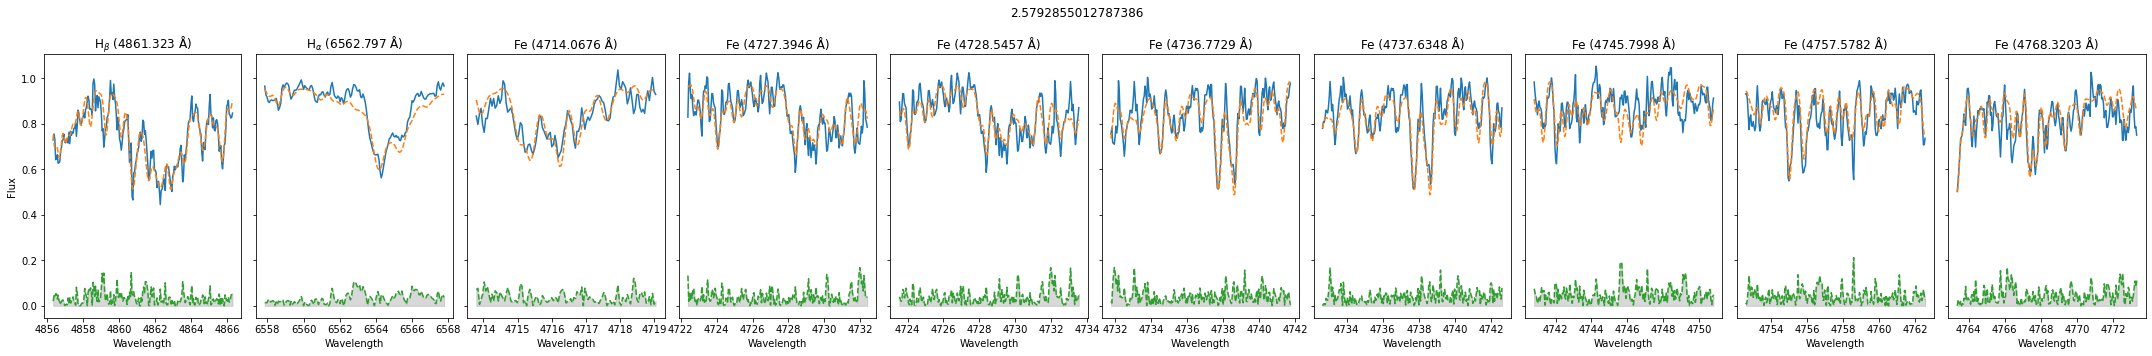

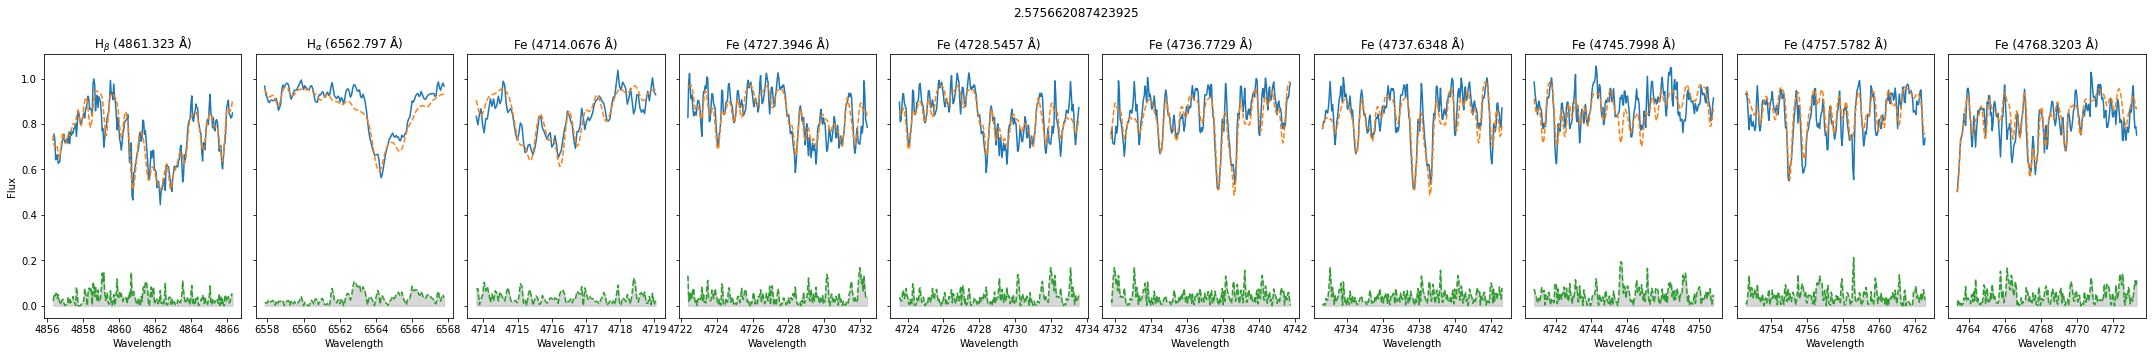

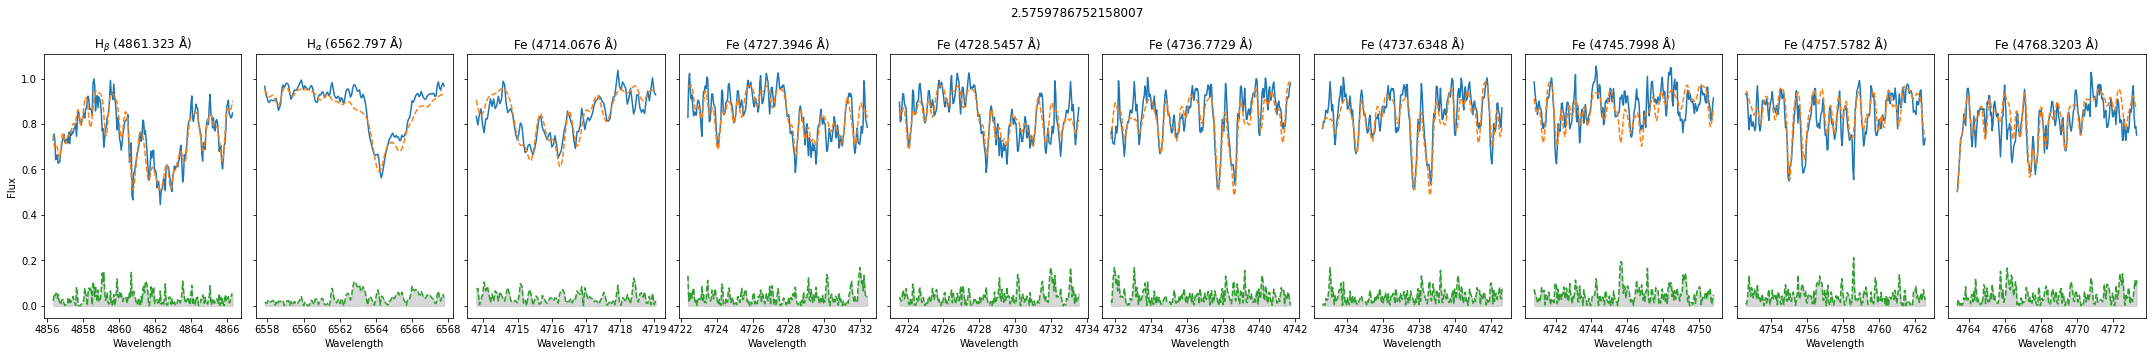

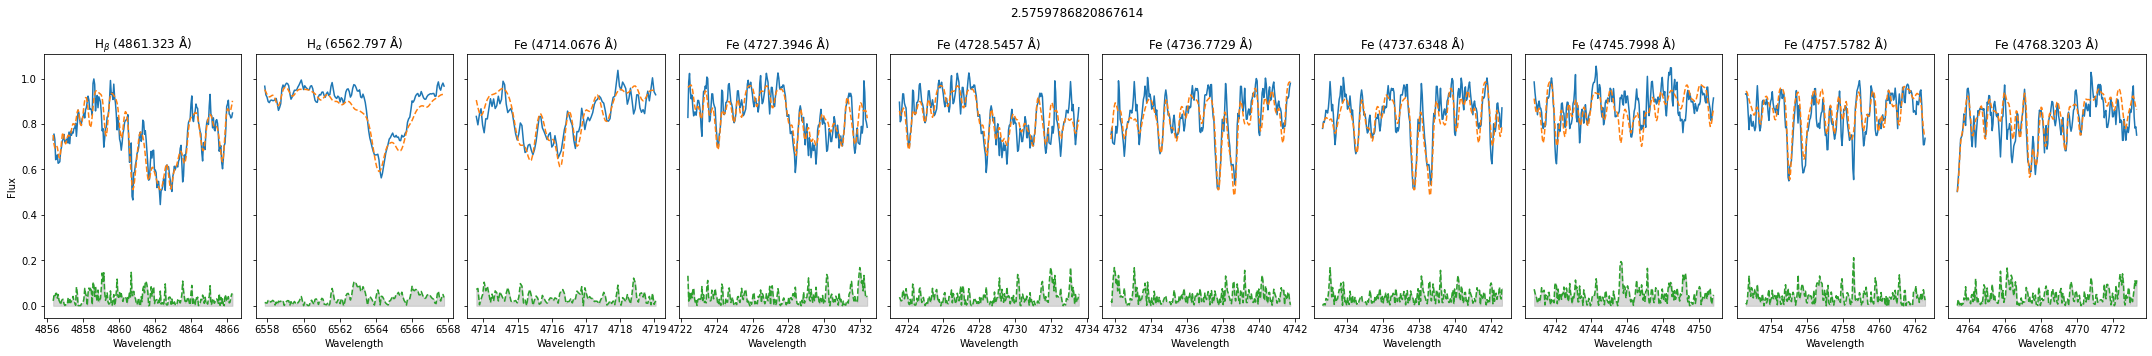

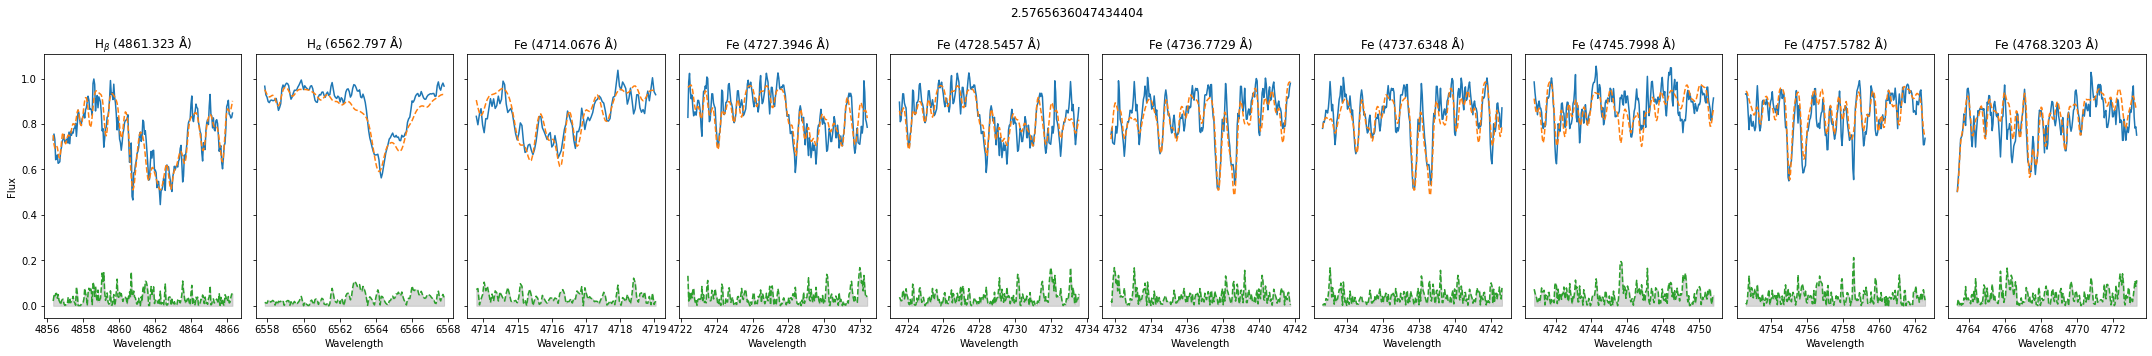

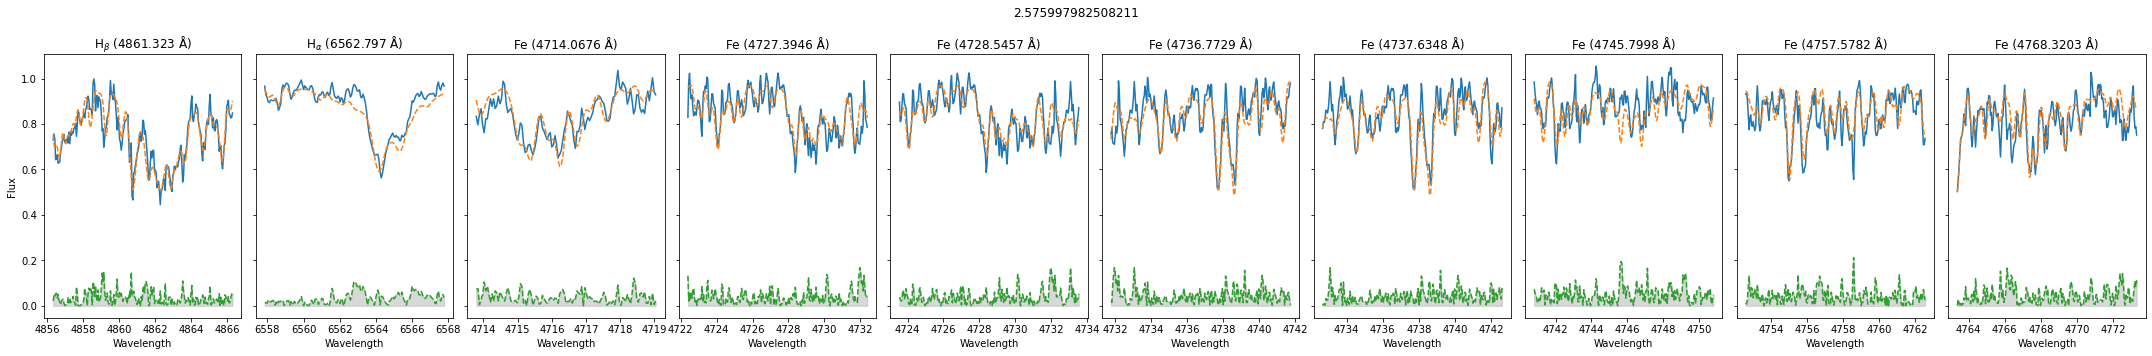

In [3]:
sobject_id = 131216002101139
sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
tmass_id = sobject_data['tmass_id'].values[0]

spectrum = af.read_spectrum(sobject_id, tmass_id)
same_fe_h = False

try:
    single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
except:
    print('Single results not available')
    exit()

model = StellarModel()

model.bounds['f_contr'] = (0, 1)

# Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
model.set_bounds('rv', (-900, 900))
model.set_bounds('teff', (3, 8))
model.set_bounds('logg', (0.0, 5.0))
model.set_bounds('fe_h', (-4.0, 1.0))
model.set_bounds('vmic', (0, 4))
model.set_bounds('vsini', (0, 30))

model.params['f_contr'] = 0.5

model.params['rv_1'] = single_results['rv_gauss'][0]
model.params['rv_2'] = single_results['rv_peak_2'][0]

model.set_param('teff', single_results['teff'][0]/1000.)
model.set_param('logg', single_results['logg'][0])
model.set_param('fe_h', single_results['fe_h'][0])
model.set_param('vmic', 1.5)
model.set_param('vsini', 4.0)

# Because we are likely dealing with a binary,
# we should at least partially take into account possibly wrong logg
model.params['logg_1'] += 0.2
model.params['logg_2'] += 0.2

af.load_neural_network(spectrum)
af.set_iterations(0)
af.load_dr3_lines()

# Generate an initial model with the starting parameters
wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, same_fe_h)
unmasked = unmasked_init


# Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
kwargs={'maxfev':10000,'xtol':1e-4}
model_parameters_iter1, covariances_iter1 = curve_fit(
    lambda wave_init, 
        *model_parameters: af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=True),
    wave_init[unmasked_init],
    data_init[unmasked_init],
    p0=model.get_params(),
    sigma=np.sqrt(sigma2_init[unmasked_init]),
    absolute_sigma=True,
    bounds=model.get_bounds(),
    **kwargs
)

Succsefully found file for object /avatar/buder/GALAH_DR4/observations/131216/spectra/com/1312160021011391.fits
done


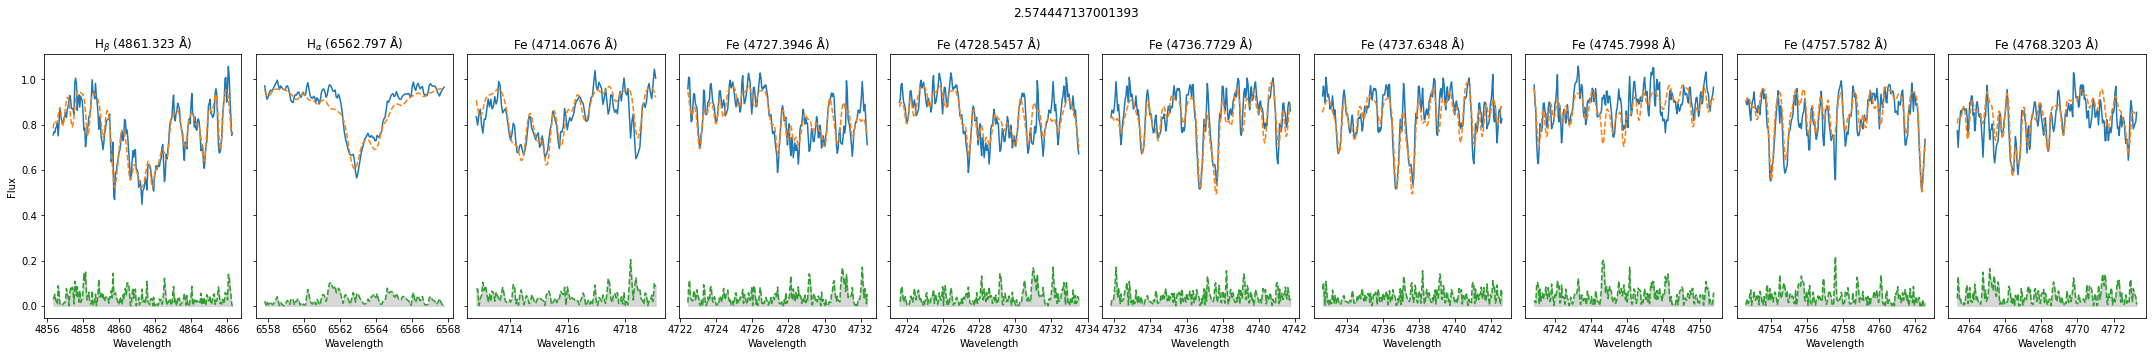

In [61]:

sobject_id = 131216002101139
sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
tmass_id = sobject_data['tmass_id'].values[0]

spectrum = af.read_spectrum(sobject_id, tmass_id)


same_fe_h = False
# model_labels = np.array(['f_contr','rv_1','teff_1','logg_1','fe_h_1','vmic_1','vsini_1','rv_2','teff_2','logg_2','fe_h_2','vmic_2','vsini_2'])


if same_fe_h:
    bounds = [(0.0,-900,3.0,0.0,-4.0,0.0,0.0,-900,3.0,-0.5,0.0,0.0), (1.0,900,8.,5.0,1.0,4.0,30.0,900,8.,5.5,4.0,30.0)]
else:
    bounds = [(0.0,-900,3.0,0.0,-4.0,0.0,0.0,-900,3.0,-0.5,-4.0,0.0,0.0), (1.0,900,8.,5.0,1.0,4.0,30.0,900,8.,5.5,1.0,4.0,30.0)]


try:
    single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
except:
    print('Single results not available')
    exit()

initial_model_parameters = np.array([
    0.5, 
    single_results['rv_gauss'][0], 
    (single_results['teff'][0]/1000.).clip(min=3.1,max=7.9), 
    (single_results['logg'][0]).clip(min=0.1,max=4.5), 
    (single_results['fe_h'][0]).clip(min = -3.9, max=0.9), 
    1.5, 
    4., 
    single_results['rv_peak_2'][0], 
    (single_results['teff'][0]/1000.).clip(min=3.1,max=7.9), 
    (single_results['logg'][0]).clip(min=0.1,max=4.5), 
    (single_results['fe_h'][0]).clip(min = -3.9, max=0.9), 
    1.5, 
    4.
])

# print(initial_model_parameters)

# Because we are likely dealing with a binary,
# we should at least partially take into account possibly wrong logg
initial_model_parameters[3] += 0.2
initial_model_parameters[9] += 0.2

af.load_neural_network(spectrum)


importlib.reload(af)

# Create an initial model to pass to the optimiser.
# wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model.params, model.model_labels, spectrum, same_fe_h)
wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, same_fe_h)
unmasked = unmasked_init

print("done")

# plotting_callback = af.PlottingCallback(wave_init, data_init, model_init, spectrum, same_fe_h)
af.set_iterations(0)
af.load_dr3_lines()

# Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
kwargs={'maxfev':10000,'xtol':1e-4}
model_parameters_iter1, covariances_iter1 = curve_fit(
    lambda wave_init, 
        *model_parameters: af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=False),
    wave_init[unmasked_init],
    data_init[unmasked_init],
    p0=initial_model_parameters,
    sigma=np.sqrt(sigma2_init[unmasked_init]),
    absolute_sigma=True,
    bounds=bounds,
    **kwargs
)

# Use the fitted parameters to generate a final model
wave_iter1, data_iter1, sigma2_iter1, model_iter1, unmasked_iter1 = af.return_wave_data_sigma_model(model, spectrum, same_fe_h)


model.generate_model(spectrum)
model.plot()

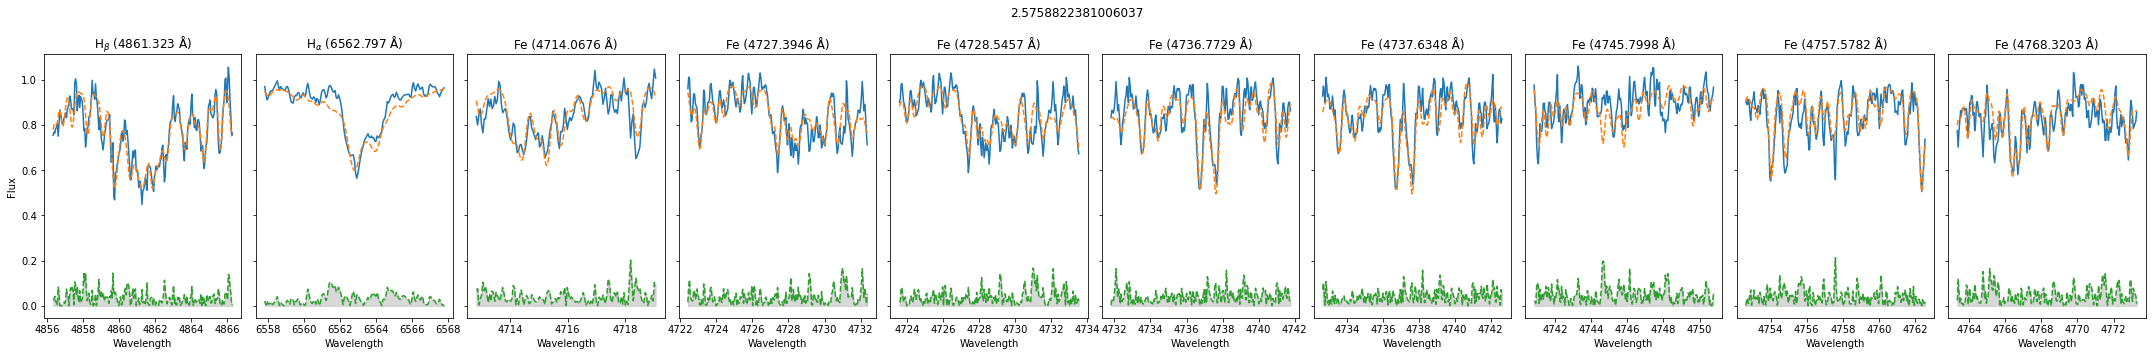

wave,sob,uob,smod,mob
float64,float64,float64,float64,bool
4712.807248783402,0.8377494798193145,0.040011687948020104,0.9081564299831242,True
4712.853270574516,0.8005894656497954,0.03880980391422821,0.8761979950792974,True
4712.899292365629,0.8473295663129368,0.03964869690427325,0.8515193698275472,True
4712.945314156742,0.8717163316620767,0.040645416704673455,0.8422177229572496,True
4712.991335947856,0.8001108438335998,0.039693427510082105,0.8500412280558998,True
4713.037357738969,0.7655396790019225,0.038630954226384726,0.870041972747887,True
4713.083379530082,0.8273962972643376,0.03906836096064783,0.8936049267051984,True
4713.1294013211955,0.8267750159678164,0.03908979228812052,0.9129577568931535,True
4713.1754231123095,0.8724902745062434,0.04017302951466742,0.9249173586648332,True


In [60]:



# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

save_spectrum

In [52]:

important_lines, important_molecules = af.load_dr3_lines()
len(important_lines)
important_lines[0:10][0][2]

'H$_\\beta$'

In [ ]:
# mass, log(age), m_h
star_1 = isochrone_interpolator(1, 9, 0)
print(star_1)

isochrone_table = Table.read('BinaryAnalysis/assets/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
isochrone_table